# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    x_train = np.hstack((x_train, y_train))
    x_test = np.hstack((x_test, np.random.normal(size = (x_test.shape[0], y_train.shape[1]))))
    x_test_ = np.hstack((x_test_, np.random.normal(size = (x_test_.shape[0], y_train.shape[1]))))

    #x_test = np.hstack((x_test, y_test))
    
preprocess.x_train.std()

0.99186991653217405

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 124
    classes = 2
    hidden_encoder_dim = 124
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 124
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            self.x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
            self.y = tf.slice(self.x_hat, [0,input_dim-2], [-1,-1])

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            loss = tf.where(tf.is_nan(self.regularized_loss), 1e-2, self.regularized_loss)
            
            correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate= self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    #print("Step {} | Training Loss:".format(epoch), end = " " )
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                      net.regularized_loss, 
                                                      ], #net.summary_op
                                                      feed_dict={net.x: x_train[i,:], 
                                                                 net.y_: y_train[i,:], 
                                                                 net.keep_prob:1, net.lr:lr})

                        train_batch()

                        count = 10
                        if((train_loss > 1e9 or np.isnan(train_loss) ) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()
                            count -= 1

                        #summary_writer_train.add_summary(summary_str, epoch)
                        #if(train_loss > 1e9):

                        #print("{:.6f}".format(train_loss), end = ", " )

                    #print("")
                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})


                    accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, 
                                                                                           net.pred, 
                                                                                           net.actual, net.y], 
                                                                                          feed_dict={net.x: preprocess.x_test_, 
                                                                                                     net.y_: preprocess.y_test_, 
                                                                                                     net.keep_prob:1, net.lr:lr})
                    #print("*************** \n")
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, test_loss, accuracy, accuracy_))
                    #print("*************** \n")
                    #print("Accuracy on Test data: {}".format(accuracy))


                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(epochs,h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})

            

In [ ]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]



    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [4, 8, 32, 122]
        hidden_layers_arr = [3, 5]

        epochs = [15]
        lrs = [1e-2, 1e-2, 1e-3]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)

        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/tf_vae_only_vae_loss_nsl_kdd_all.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_all.pkl")

        past_scores.append(temp).to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_all.pkl")

        

In [ ]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:15 hidden layers:3 features count:4
Step 1 | Training Loss: 0.000779 | Test Loss: 0.004162 | Test Accuracy: 0.812899, 0.719662
Step 2 | Training Loss: 0.000968 | Test Loss: 0.003908 | Test Accuracy: 0.820085, 0.737468
Step 3 | Training Loss: 0.000938 | Test Loss: 0.003552 | Test Accuracy: 0.798128, 0.671477
Step 4 | Training Loss: 0.000378 | Test Loss: 0.004560 | Test Accuracy: 0.792229, 0.638565
Step 5 | Training Loss: 0.000038 | Test Loss: 0.004106 | Test Accuracy: 0.802608, 0.675190
Step 6 | Training Loss: 0.000358 | Test Loss: 0.004417 | Test Accuracy: 0.807532, 0.754684
Step 7 | Training Loss: 0.000040 | Test Loss: 0.004060 | Test Accuracy: 0.809129, 0.709958
Step 8 | Training Loss: 0.000322 | Test Loss: 0.004401 | Test Accuracy: 0.796930, 0.715021
Step 9 | Training Loss: 0.000813 | Test Loss: 0.006197 | Test Accuracy: 0.814585, 0.794093
Step 10 | Training Loss: 0.000422 | Test Loss: 0.004057 | Test Accuracy: 0.820396, 0.769536
Step 11 | Training 

Step 15 | Training Loss: 0.000099 | Test Loss: 0.005792 | Test Accuracy: 0.791208, 0.812911
Current Layer Attributes - epochs:15 hidden layers:3 features count:32
Step 1 | Training Loss: 0.000420 | Test Loss: 0.003586 | Test Accuracy: 0.847720, 0.730464
Step 2 | Training Loss: 0.000844 | Test Loss: 0.339398 | Test Accuracy: 0.767920, 0.643797
Step 3 | Training Loss: 0.000760 | Test Loss: 0.006361 | Test Accuracy: 0.854374, 0.734937
Step 4 | Training Loss: 0.000915 | Test Loss: 0.003443 | Test Accuracy: 0.843994, 0.772996
Step 5 | Training Loss: 0.000187 | Test Loss: 0.004042 | Test Accuracy: 0.847454, 0.782869
Step 6 | Training Loss: 0.000032 | Test Loss: 0.005870 | Test Accuracy: 0.815561, 0.829283
Step 7 | Training Loss: 0.000102 | Test Loss: 0.006415 | Test Accuracy: 0.757097, 0.834093
Step 8 | Training Loss: 0.000378 | Test Loss: 0.005476 | Test Accuracy: 0.784954, 0.812321
Step 9 | Training Loss: 0.000401 | Test Loss: 0.005198 | Test Accuracy: 0.776304, 0.825654
Step 10 | Training

Step 9 | Training Loss: 0.000026 | Test Loss: 0.010109 | Test Accuracy: 0.709413, 0.766920
Step 10 | Training Loss: 0.000055 | Test Loss: 0.010330 | Test Accuracy: 0.709856, 0.768270
Step 11 | Training Loss: 0.000090 | Test Loss: 0.009965 | Test Accuracy: 0.710211, 0.768017
Step 12 | Training Loss: 0.000245 | Test Loss: 0.010381 | Test Accuracy: 0.706352, 0.763122
Step 13 | Training Loss: 0.000130 | Test Loss: 0.010262 | Test Accuracy: 0.704622, 0.766751
Step 14 | Training Loss: 0.000131 | Test Loss: 0.011017 | Test Accuracy: 0.701029, 0.761603
Step 15 | Training Loss: 0.000033 | Test Loss: 0.010811 | Test Accuracy: 0.704223, 0.764135
Current Layer Attributes - epochs:15 hidden layers:5 features count:4
Step 1 | Training Loss: 0.000742 | Test Loss: 0.008072 | Test Accuracy: 0.430758, 0.181603
Step 2 | Training Loss: 0.000200 | Test Loss: 0.001446 | Test Accuracy: 0.769251, 0.735443
Step 3 | Training Loss: 0.001428 | Test Loss: 0.002576 | Test Accuracy: 0.792095, 0.666329
Step 4 | Train

Step 8 | Training Loss: 0.000292 | Test Loss: 0.002426 | Test Accuracy: 0.820396, 0.807257
Step 9 | Training Loss: 0.000223 | Test Loss: 0.002804 | Test Accuracy: 0.801499, 0.822025
Step 10 | Training Loss: 0.000093 | Test Loss: 0.002226 | Test Accuracy: 0.836897, 0.827426
Step 11 | Training Loss: 0.000057 | Test Loss: 0.002553 | Test Accuracy: 0.832594, 0.828270
Step 12 | Training Loss: 0.000114 | Test Loss: 0.002114 | Test Accuracy: 0.848652, 0.824726
Step 13 | Training Loss: 0.000297 | Test Loss: 0.002052 | Test Accuracy: 0.859120, 0.823797
Step 14 | Training Loss: 0.000482 | Test Loss: 0.002032 | Test Accuracy: 0.861382, 0.822532
Step 15 | Training Loss: 0.000090 | Test Loss: 0.001906 | Test Accuracy: 0.863511, 0.822532
Current Layer Attributes - epochs:15 hidden layers:5 features count:32
Step 1 | Training Loss: 0.000226 | Test Loss: 0.003575 | Test Accuracy: 0.793870, 0.695696
Step 2 | Training Loss: 0.000984 | Test Loss: 0.003467 | Test Accuracy: 0.772800, 0.664641
Step 3 | Trai

Step 4 | Training Loss: 0.007777 | Test Loss: 0.007947 | Test Accuracy: 0.430580, 0.181603
Step 5 | Training Loss: 0.006798 | Test Loss: 0.007985 | Test Accuracy: 0.431112, 0.182194
Step 6 | Training Loss: 0.007634 | Test Loss: 0.007945 | Test Accuracy: 0.431290, 0.182278
Step 7 | Training Loss: 0.006643 | Test Loss: 0.007973 | Test Accuracy: 0.434129, 0.197384
Step 8 | Training Loss: 0.008388 | Test Loss: 0.009309 | Test Accuracy: 0.431068, 0.181941
Step 9 | Training Loss: 0.007546 | Test Loss: 0.009203 | Test Accuracy: 0.436790, 0.209114
Step 10 | Training Loss: 0.006003 | Test Loss: 0.008675 | Test Accuracy: 0.430802, 0.181772
Step 11 | Training Loss: 0.006841 | Test Loss: 0.009053 | Test Accuracy: 0.430713, 0.181688
Step 12 | Training Loss: 0.007820 | Test Loss: 0.009737 | Test Accuracy: 0.434839, 0.198059
Step 13 | Training Loss: 0.008648 | Test Loss: 0.009188 | Test Accuracy: 0.450186, 0.262700
Step 14 | Training Loss: 0.010158 | Test Loss: 0.008977 | Test Accuracy: 0.430491, 0.1

Step 5 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_15_features count_3/model-3
Step 5 | Training Loss: 0.000244 | Test Loss: 0.015177 | Test Accuracy: 0.771336, 0.739831
Step 6 | Training Loss: 0.000028 | Test Loss: 0.003691 | Test Accuracy: 0.828824, 0.777553
Step 7 | Training Loss: 0.000158 | Test Loss: 0.003799 | Test Accuracy: 0.799636, 0.813080
Step 8 | Training Loss: 0.000320 | Test Loss: 0.003485 | Test Accuracy: 0.825940, 0.821857
Step 9 | Training Loss: 0.000788 | Test Loss: 0.003473 | Test Accuracy: 0.805447, 0.804641
Step 10 | Training Loss: 0.000355 | Test Loss: 0.003478 | Test Accuracy: 0.815295, 0.807342
Step 11 | Training Loss: 0.001143 | Test Loss: 0.005187 | Test Accuracy: 0.798483, 0.784304
Step 12 | Training Loss: 0.000467 | Test Loss: 0.005605 | Test Accuracy: 0.751508, 0.797975
Step 13 | Training Loss: 0.000330 | Test Loss: 0.004757 | Test Accuracy: 0.794801, 0.796118
Step 

Step 6 | Training Loss: 0.000048 | Test Loss: 0.006551 | Test Accuracy: 0.747339, 0.555274
Step 7 | Training Loss: 0.000080 | Test Loss: 0.007011 | Test Accuracy: 0.737669, 0.547257
Step 8 | Training Loss: 0.000231 | Test Loss: 0.006766 | Test Accuracy: 0.735140, 0.525485
Step 9 | Training Loss: 0.000021 | Test Loss: 0.007842 | Test Accuracy: 0.708747, 0.481941
Step 10 | Training Loss: 0.000594 | Test Loss: 0.007595 | Test Accuracy: 0.767078, 0.594768
Step 11 | Training Loss: 0.000153 | Test Loss: 0.009384 | Test Accuracy: 0.665188, 0.438650
Step 12 | Training Loss: 0.000024 | Test Loss: 0.006071 | Test Accuracy: 0.711143, 0.489030
Step 13 | Training Loss: 0.000185 | Test Loss: 0.007291 | Test Accuracy: 0.712429, 0.496287
Step 14 | Training Loss: 0.000092 | Test Loss: 0.006352 | Test Accuracy: 0.726446, 0.537300
Step 15 | Training Loss: 0.000233 | Test Loss: 0.007558 | Test Accuracy: 0.727289, 0.530211
Step 1 | Training Loss: 0.000248 | Test Loss: 0.009962 | Test Accuracy: 0.717397, 0.

Step 5 | Training Loss: 0.000053 | Test Loss: 0.004857 | Test Accuracy: 0.647401, 0.421266
Step 6 | Training Loss: 0.001331 | Test Loss: 0.007529 | Test Accuracy: 0.577936, 0.356371
Step 7 | Training Loss: 0.000890 | Test Loss: 0.002974 | Test Accuracy: 0.706219, 0.504473
Step 8 | Training Loss: 0.000262 | Test Loss: 0.003449 | Test Accuracy: 0.683419, 0.437131
Step 9 | Training Loss: 0.000055 | Test Loss: 0.002961 | Test Accuracy: 0.700275, 0.491730
Step 10 | Training Loss: 0.000480 | Test Loss: 0.002835 | Test Accuracy: 0.712119, 0.507257
Step 11 | Training Loss: 0.000276 | Test Loss: 0.006097 | Test Accuracy: 0.676765, 0.414262
Step 12 | Training Loss: 0.002061 | Test Loss: 0.008707 | Test Accuracy: 0.768630, 0.615021
Step 13 | Training Loss: 0.003022 | Test Loss: 0.003497 | Test Accuracy: 0.775639, 0.673502
Step 14 | Training Loss: 0.000717 | Test Loss: 0.002577 | Test Accuracy: 0.849184, 0.768101
Step 15 | Training Loss: 0.000018 | Test Loss: 0.002161 | Test Accuracy: 0.838139, 0.

Step 1 | Training Loss: 0.000796 | Test Loss: 0.003853 | Test Accuracy: 0.823678, 0.704219
Step 2 | Training Loss: 0.001726 | Test Loss: 0.009079 | Test Accuracy: 0.802608, 0.676371
Step 3 | Training Loss: 0.000582 | Test Loss: 0.006755 | Test Accuracy: 0.759803, 0.587089
Step 4 | Training Loss: 0.000074 | Test Loss: 0.008030 | Test Accuracy: 0.543471, 0.280675
Step 5 | Training Loss: 0.001359 | Test Loss: 1.172646 | Test Accuracy: 0.579622, 0.415949
Step 6 | Training Loss: 0.001335 | Test Loss: 0.005927 | Test Accuracy: 0.502795, 0.249367
Step 7 | Training Loss: 0.001361 | Test Loss: 0.005988 | Test Accuracy: 0.555935, 0.352321
Step 8 | Training Loss: 0.001939 | Test Loss: 0.005990 | Test Accuracy: 0.511888, 0.275359
Step 9 | Training Loss: 0.000426 | Test Loss: 0.006144 | Test Accuracy: 0.524264, 0.282363
Step 10 | Training Loss: 0.001546 | Test Loss: 0.004872 | Test Accuracy: 0.519118, 0.276709
Step 11 | Training Loss: 0.001838 | Test Loss: 0.006991 | Test Accuracy: 0.518852, 0.2732

Step 15 | Training Loss: 0.000406 | Test Loss: 0.002580 | Test Accuracy: 0.715046, 0.475865
Current Layer Attributes - epochs:15 hidden layers:3 features count:8
Step 1 | Training Loss: 0.000350 | Test Loss: 0.007818 | Test Accuracy: 0.785531, 0.617975
Step 2 | Training Loss: 0.000667 | Test Loss: 0.007308 | Test Accuracy: 0.771159, 0.593671
Step 3 | Training Loss: 0.000604 | Test Loss: 0.008927 | Test Accuracy: 0.771070, 0.603544
Step 4 | Training Loss: 0.002147 | Test Loss: 0.008470 | Test Accuracy: 0.798128, 0.679662
Step 5 | Training Loss: 0.000070 | Test Loss: 0.006349 | Test Accuracy: 0.824743, 0.718903
Step 6 | High Training Loss: 201584992416782939586560.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_15_features count_3/model-5
Step 6 | Training Loss: 0.000599 | Test Loss: 0.006661 | Test Accuracy: 0.834989, 0.730717
Step 7 | Training Loss: 0.000089 | Test Loss: 0.006081 | Test Accuracy: 0.829578, 0.718397
S

Step 9 | Training Loss: 0.000019 | Test Loss: 0.012292 | Test Accuracy: 0.690561, 0.610211
Step 10 | Training Loss: 0.000044 | Test Loss: 0.012251 | Test Accuracy: 0.687988, 0.608354
Step 11 | Training Loss: 0.000072 | Test Loss: 0.012404 | Test Accuracy: 0.687633, 0.608186
Step 12 | Training Loss: 0.000089 | Test Loss: 0.012562 | Test Accuracy: 0.690472, 0.612574
Step 13 | Training Loss: 0.000174 | Test Loss: 0.012367 | Test Accuracy: 0.691581, 0.627173
Step 14 | Training Loss: 0.000096 | Test Loss: 0.012645 | Test Accuracy: 0.687456, 0.612827
Step 15 | Training Loss: 0.000069 | Test Loss: 0.012429 | Test Accuracy: 0.688387, 0.618987
Current Layer Attributes - epochs:15 hidden layers:3 features count:122
Step 1 | Training Loss: 0.000009 | Test Loss: 0.076514 | Test Accuracy: 0.715135, 0.483713
Step 2 | High Training Loss: 43928624855777280.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_only_vae_loss_nsl_kdd/hidden layers_15_features count_3/model-1
S

Step 5 | Training Loss: 0.000475 | Test Loss: 0.001805 | Test Accuracy: 0.786373, 0.607679
Step 6 | Training Loss: 0.000447 | Test Loss: 0.001953 | Test Accuracy: 0.787172, 0.606160
Step 7 | Training Loss: 0.000197 | Test Loss: 0.001766 | Test Accuracy: 0.785397, 0.604051
Step 8 | Training Loss: 0.000402 | Test Loss: 0.001726 | Test Accuracy: 0.786418, 0.606582
Step 9 | Training Loss: 0.000099 | Test Loss: 0.001839 | Test Accuracy: 0.787748, 0.607257
Step 10 | Training Loss: 0.000092 | Test Loss: 0.001553 | Test Accuracy: 0.786817, 0.607089
Step 11 | Training Loss: 0.000152 | Test Loss: 0.001636 | Test Accuracy: 0.787349, 0.606835
Step 12 | Training Loss: 0.000007 | Test Loss: 0.001661 | Test Accuracy: 0.787881, 0.607764
Step 13 | Training Loss: 0.000117 | Test Loss: 0.001593 | Test Accuracy: 0.787881, 0.609283
Step 14 | Training Loss: 0.000205 | Test Loss: 0.001582 | Test Accuracy: 0.787527, 0.609114
Step 15 | Training Loss: 0.000362 | Test Loss: 0.001819 | Test Accuracy: 0.788236, 0.

Step 1 | Training Loss: 0.000238 | Test Loss: 0.002215 | Test Accuracy: 0.813786, 0.660422
Step 2 | Training Loss: 0.000054 | Test Loss: 0.002385 | Test Accuracy: 0.813520, 0.659831
Step 3 | Training Loss: 0.000332 | Test Loss: 0.002324 | Test Accuracy: 0.816004, 0.662194
Step 4 | Training Loss: 0.000222 | Test Loss: 0.002352 | Test Accuracy: 0.816492, 0.663291
Step 5 | Training Loss: 0.000053 | Test Loss: 0.002323 | Test Accuracy: 0.812944, 0.657722
Step 6 | Training Loss: 0.000167 | Test Loss: 0.002314 | Test Accuracy: 0.811036, 0.655021
Step 7 | Training Loss: 0.000061 | Test Loss: 0.002297 | Test Accuracy: 0.813210, 0.658987
Step 8 | Training Loss: 0.000023 | Test Loss: 0.002362 | Test Accuracy: 0.815161, 0.661097
Step 9 | Training Loss: 0.000111 | Test Loss: 0.002207 | Test Accuracy: 0.814895, 0.663122
Step 10 | Training Loss: 0.000015 | Test Loss: 0.002071 | Test Accuracy: 0.816847, 0.665148
Step 11 | Training Loss: 0.000081 | Test Loss: 0.002202 | Test Accuracy: 0.814363, 0.6625

In [21]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
2,45,32,3,0.897285,0.893808,0.824726,3.912326
3,45,122,3,0.910700,0.860894,0.811814,9.294263
0,45,4,3,0.925464,0.854640,0.795021,89.629435
5,45,8,5,0.907604,0.839603,0.702616,124.541892


In [22]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
2,45,32,3,0.897285,0.893808,0.824726,3.912326
6,45,32,5,0.914272,0.877085,0.794430,11.106694
3,45,122,3,0.910700,0.860894,0.811814,9.294263
0,45,4,3,0.925464,0.854640,0.795021,89.629435
5,45,8,5,0.907604,0.839603,0.702616,124.541892
7,45,122,5,0.937292,0.834679,0.724979,170.694251
1,45,8,3,0.939594,0.820174,0.753586,11.025270
4,45,4,5,0.848468,0.812633,0.688186,32.484117


In [23]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_scores.pkl")

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9321  0.0679]
 [ 0.1308  0.8692]]


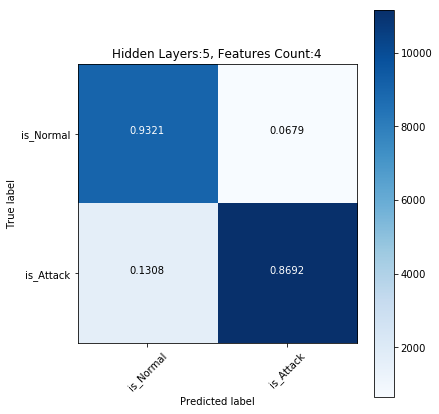

In [25]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.7858  0.2142]
 [ 0.1754  0.8246]]


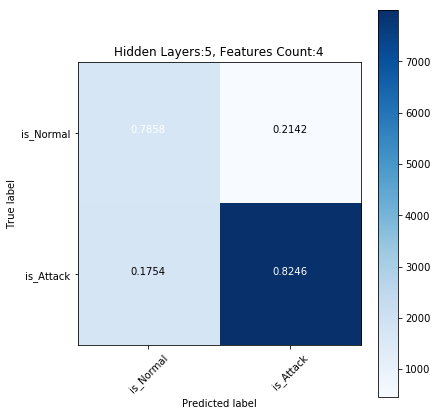

In [26]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [27]:
past_scores

,,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,hidden_layers,,,,,
8,3,45,0.933878,0.864487,0.773080,56.184884
32,3,45,0.942769,0.814895,0.750380,149.667458
122,3,45,0.946738,0.768675,0.575612,6.564366
8,5,45,0.783775,0.858632,0.786160,182.730184
32,5,45,0.835450,0.824610,0.723038,190.228723
122,5,45,0.926893,0.806290,0.679072,9.157173
8,3,45,0.933878,0.864487,0.773080,56.184884
32,3,45,0.942769,0.814895,0.750380,149.667458
122,3,45,0.946738,0.768675,0.575612,6.564366


In [30]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean()

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
4              3                 45     0.905478    0.848246       0.762869   
               5                 45     0.874430    0.853582       0.760030   
8              3                 45     0.932218    0.836769       0.741220   
               5                 45     0.878241    0.849433       0.745122   
32             3                 45     0.930502    0.842015       0.741285   
               5                 45     0.900726    0.841872       0.733661   
122            3                 45     0.930080    0.821276       0.712713   
               5                 45     0.908478    0.833360       0.723307   

                              time_taken  
no_of_features hidden_layers              
4              3               68.463217  
               5              105.413531  
8              3               53.515072  
               5              105.267146  
32             3               36.442210  
               5               85.737220  
122            3               30.276869  
               5               69.061075

In [29]:
pgb.std()

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
4              3                0.0     0.027673    0.030943       0.052406   
               5                0.0     0.038355    0.033142       0.054344   
8              3                0.0     0.017941    0.026494       0.041137   
               5                0.0     0.041464    0.033766       0.070242   
32             3                0.0     0.015369    0.022095       0.046647   
               5                0.0     0.041707    0.033306       0.056131   
122            3                0.0     0.027497    0.029783       0.063613   
               5                0.0     0.033715    0.029876       0.059322   

                              time_taken  
no_of_features hidden_layers              
4              3               49.880257  
               5               62.122828  
8              3               48.249231  
               5               61.405989  
32             3               50.888603  
               5               66.039826  
122            3               40.722067  
               5               97.432520